In [2]:
import pandas as pd

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a pair of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [ ]:
# If haven't downloaded it yet, please get the data file with wget
!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ./data/

1\. Create a Pandas DataFrame reading N rows of the `data/data_000637.txt` dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k (check the documentation).

In [3]:
file_name = "./data/data_000637.txt"
N=11000
data = pd.read_csv(file_name,nrows=N)
data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
10995,1,0,139,3869200277,204,0
10996,1,0,61,3869200277,202,20
10997,1,0,63,3869200277,204,1
10998,1,0,59,3869200277,283,29


2\. Estimate the number of BX in a ORBIT (the value 'x').

In [4]:
x=data['BX_COUNTER'].max()+1
print(x)

3564


3\. Find out the duration of the data taking in hours, minutes and seconds. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading the whole dataset.

In [5]:
start=data.min(axis=0)
end=data.max(axis=0)
end_ns=(end)['TDC_MEAS']*25/30+(end)['BX_COUNTER']*25+(end)['ORBIT_CNT']*x*25
start_ns=(start)['TDC_MEAS']*25/30+(start)['BX_COUNTER']*25+(start)['ORBIT_CNT']*x*25
print(pd.to_timedelta(end_ns-start_ns))

0 days 00:00:00.009890099


4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information) since the beginning of the data acquisition.

In [46]:
abs_time=[]
for index,row in data.iterrows():
    temp=float(row['TDC_MEAS']*25/30+row['BX_COUNTER']*25+row['ORBIT_CNT']*x*25)
    abs_time.append(temp)

data['ABSOLUTE_NS']=abs_time
data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,ABSOLUTE_NS
0,1,0,123,3869200167,2374,26,3.447457e+14
1,1,0,124,3869200167,2374,27,3.447457e+14
2,1,0,63,3869200167,2553,28,3.447457e+14
3,1,0,64,3869200167,2558,19,3.447457e+14
4,1,0,64,3869200167,2760,25,3.447457e+14
...,...,...,...,...,...,...,...
10995,1,0,139,3869200277,204,0,3.447457e+14
10996,1,0,61,3869200277,202,20,3.447457e+14
10997,1,0,63,3869200277,204,1,3.447457e+14
10998,1,0,59,3869200277,283,29,3.447457e+14


5\. Use the `.groupby()` method to find out the noisy channels, i.e. the TDC channels with most counts (print to screen the top 3 and the corresponding counts)

In [8]:
data.groupby('TDC_CHANNEL').count().sort_values(by='HEAD',ascending=False).iloc[0:3]

,HEAD,FPGA,ORBIT_CNT,BX_COUNTER,TDC_MEAS
TDC_CHANNEL,,,,,
139,941,941,941,941,941
64,554,554,554,554,554
63,548,548,548,548,548


6\. Count the number of non-empty orbits (i.e. the number of orbits with at least one hit). Count also the number of unique orbits with at least one measurement from TDC_CHANNEL=139.

In [11]:
print(len(data.groupby('ORBIT_CNT').count()))
print(len(data[data['TDC_CHANNEL']==139].groupby('ORBIT_CNT').count()))

111
111


7\. **Optional:** Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

Text(0, 0.5, 'COUNTS')

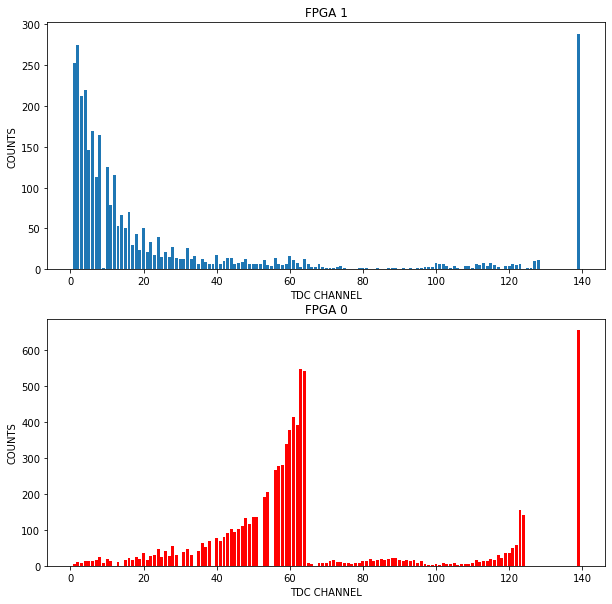

In [29]:
import matplotlib.pyplot as plt

fpga1 = data[data['FPGA']==1].groupby('TDC_CHANNEL').count()['HEAD'].values
index1 = data[data['FPGA']==1].groupby('TDC_CHANNEL').count().index
fpga0 = data[data['FPGA']==0].groupby('TDC_CHANNEL').count()['HEAD'].values
index0 = data[data['FPGA']==0].groupby('TDC_CHANNEL').count().index

fig,axs = plt.subplots(2,figsize=(10,10))
axs[0].bar(index1,fpga1)
axs[0].set_title('FPGA 1')
axs[0].set_xlabel('TDC CHANNEL')
axs[0].set_ylabel('COUNTS')
axs[1].bar(index0,fpga0,color='r')
axs[1].set_title('FPGA 0')
axs[1].set_xlabel('TDC CHANNEL')
axs[1].set_ylabel('COUNTS')